In [10]:
!pip -q install yfinance ta scikit-learn pandas numpy matplotlib huggingface_hub skops


In [ ]:
import os, math, numpy as np, pandas as pd, yfinance as yf
from datetime import datetime
from huggingface_hub import login, HfApi, create_repo, upload_file
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import skops.io as sio
import matplotlib.pyplot as plt

In [ ]:
UNIVERSE = "sp500"
START = "2015-01-01"
END   = None         # None = today
MAX_TICKERS = 150

In [ ]:
# Robust S&P 500 fetch (Wikipedia -> DataHub
import pandas as pd, requests

SP500_WIKI = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP500_CSV  = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"  # fallback

def _to_yahoo_symbol(sym: str) -> str:

    return sym.strip().upper().replace(".", "-")

def get_sp500_tickers(limit=None):

    try:
        tables = pd.read_html(SP500_WIKI)
        df = tables[0]
        syms = df["Symbol"].astype(str).map(_to_yahoo_symbol).tolist()
        if not syms:
            raise ValueError("Empty symbols from Wikipedia")
        syms = list(dict.fromkeys(syms))
        return syms[:limit] if limit else syms
    except Exception as e:
        print("Wikipedia read_html failed:", e)


    try:
        headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                                 "(KHTML, like Gecko) Chrome/124.0 Safari/537.36"}
        html = requests.get(SP500_WIKI, headers=headers, timeout=20).text
        tables = pd.read_html(html)
        df = tables[0]
        syms = df["Symbol"].astype(str).map(_to_yahoo_symbol).tolist()
        syms = list(dict.fromkeys(syms))
        if syms:
            return syms[:limit] if limit else syms
    except Exception as e:
        print("Wikipedia + UA fallback failed:", e)


    try:
        df = pd.read_csv(SP500_CSV)
        syms = df["Symbol"].astype(str).map(_to_yahoo_symbol).tolist()
        syms = list(dict.fromkeys(syms))
        if syms:
            return syms[:limit] if limit else syms
    except Exception as e:
        print("DataHub CSV fallback failed:", e)


    print("⚠️ Using hardcoded fallback tickers.")
    base = ["AAPL","MSFT","AMZN","GOOGL","META","NVDA","TSLA","JPM","XOM","JNJ","PG","UNH","V","MA"]
    return base[:limit] if limit else base


MAX_TICKERS = 150
tickers = get_sp500_tickers(limit=MAX_TICKERS)
print(f"Got {len(tickers)} tickers (first 10):", tickers[:10])

# Download with yfinance
import yfinance as yf
START = "2015-01-01"; END = None

data = yf.download(
    tickers=tickers,
    start=START,
    end=END,
    interval="1d",
    group_by="ticker",
    auto_adjust=True,
    threads=True
)

import pandas as pd

frames = []
is_multi = isinstance(data.columns, pd.MultiIndex)

for t in tickers:
    try:

        df_t = data.xs(t, axis=1, level=0) if is_multi else data.copy()
        if df_t.empty:
            continue

        # Ensure index becomes a 'date' column (fixes 'Date' vs 'index' issues)
        df_t = df_t.copy()
        df_t.index.name = "date"
        df_t = df_t.reset_index()

        # Standardize column names
        df_t.columns = [c.lower() for c in df_t.columns]


        needed = ["date","open","high","low","close","volume"]
        if any(c not in df_t.columns for c in needed):
            continue

        df_t["ticker"] = t
        frames.append(df_t[needed + ["ticker"]])
    except Exception:

        continue

if not frames:
    raise RuntimeError("No valid OHLCV frames collected. Try lowering MAX_TICKERS or changing date range.")

df = pd.concat(frames, ignore_index=True).dropna(subset=["open","high","low","close","volume"])
df = df.sort_values(["ticker","date"]).reset_index(drop=True)

print(f"✅ Pulled {df['ticker'].nunique()} tickers, {len(df):,} rows.")
display(df.head())

Wikipedia read_html failed: HTTP Error 403: Forbidden


/tmp/ipython-input-3524998370.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


Got 150 tickers (first 10): ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


[*********************100%***********************]  150 of 150 completed


✅ Pulled 150 tickers, 394,334 rows.


,date,open,high,low,close,volume,ticker
0,2015-01-02,37.688375,37.807353,36.947053,37.120945,1529200.0,A
1,2015-01-05,36.901298,37.029427,36.333869,36.425388,2041800.0,A
2,2015-01-06,36.434540,36.626733,35.711522,35.857956,2080600.0,A
3,2015-01-07,36.169128,36.434540,35.958630,36.333866,3359700.0,A
4,2015-01-08,36.828077,37.505331,36.773163,37.422962,2116300.0,A


In [ ]:
# FEATURES (+ LABEL)
!pip -q install ta

import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands

feature_cols = [
    "ret_1d","ret_5d","vol_5d","vol_20d",
    "rsi14","macd","macd_signal","macd_hist",
    "bb_pct","sma_ratio"
]

def add_features(g):
    g = g.copy()
    g["ret_1d"] = g["close"].pct_change()
    g["ret_5d"] = g["close"].pct_change(5)
    g["vol_5d"] = g["ret_1d"].rolling(5).std()
    g["vol_20d"] = g["ret_1d"].rolling(20).std()

    rsi = RSIIndicator(close=g["close"], window=14)
    g["rsi14"] = rsi.rsi()

    macd = MACD(close=g["close"], window_slow=26, window_fast=12, window_sign=9)
    g["macd"] = macd.macd()
    g["macd_signal"] = macd.macd_signal()
    g["macd_hist"] = macd.macd_diff()

    bb = BollingerBands(close=g["close"], window=20, window_dev=2)
    g["bb_high"] = bb.bollinger_hband()
    g["bb_low"]  = bb.bollinger_lband()
    g["bb_pct"]  = (g["close"] - g["bb_low"]) / (g["bb_high"] - g["bb_low"])

    g["sma10"] = SMAIndicator(close=g["close"], window=10).sma_indicator()
    g["sma20"] = SMAIndicator(close=g["close"], window=20).sma_indicator()
    g["sma_ratio"] = g["sma10"] / g["sma20"]

    # Label: next-day up (1) / down (0) — **shift(-1) to predict tomorrow**
    g["next_ret_1d"] = g["close"].pct_change().shift(-1)
    g["y"] = (g["next_ret_1d"] > 0).astype(int)
    return g

df_feat = df.groupby("ticker", group_keys=False).apply(add_features)
df_feat = df_feat.dropna(subset=feature_cols + ["y"]).sort_values(["ticker","date"]).reset_index(drop=True)

print(df_feat[["date","ticker","close","y"]+feature_cols].head())


/tmp/ipython-input-3834849685.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df.groupby("ticker", group_keys=False).apply(add_features)


        date ticker      close  y    ret_1d    ret_5d    vol_5d   vol_20d  \
0 2015-02-20      A  38.393089  0  0.019441  0.048226  0.013605  0.015678   
1 2015-02-23      A  38.191742  1 -0.005244  0.039352  0.015041  0.014766   
2 2015-02-24      A  38.493771  1  0.007908  0.038006  0.015022  0.014752   
3 2015-02-25      A  38.621899  1  0.003329  0.015888  0.011355  0.014386   
4 2015-02-26      A  38.768314  0  0.003791  0.029404  0.008981  0.013264   

       rsi14      macd  macd_signal  macd_hist    bb_pct  sma_ratio  
0  65.428523  0.438390     0.147409   0.290981  1.061656   1.018745  
1  63.349603  0.505135     0.218954   0.286181  0.941124   1.021020  
2  65.138964  0.575765     0.290317   0.285449  0.941840   1.024874  
3  65.899570  0.634762     0.359206   0.275556  0.911072   1.026779  
4  66.791232  0.685430     0.424451   0.260980  0.896580   1.028748  


[*********************100%***********************]  1 of 1 completed


             Model    ACC    AUC      P      R     F1    TP    FP    TN    FN  Thresh
LogReg(bal,scaled) 0.5173 0.5198 0.5161 0.9980 0.6804 19984 18734   136    40   0.405
 RandomForest(bal) 0.5176 0.5137 0.5164 0.9944 0.6797 19911 18650   220   113   0.400
           XGBoost 0.5150 0.5090 0.5154 0.9705 0.6732 19433 18272   598   591   0.400
         Always Up 0.5148 0.5000 0.5148 1.0000 0.6797 20024 18870     0     0     NaN
       Always Down 0.4852 0.5000 0.0000 0.0000 0.0000     0     0 18870 20024     NaN


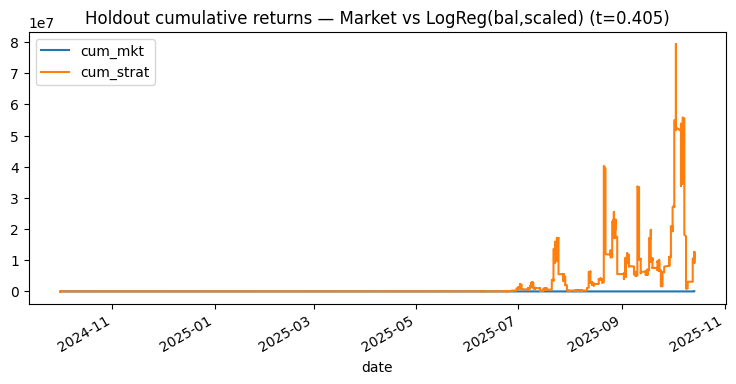

In [ ]:

# (LogReg + RF + XGB, with SPY feature)

!pip -q install xgboost

import numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 0) Add SPY daily return as market context
df_feat["date"] = pd.to_datetime(df_feat["date"])

spy = yf.download("SPY",
                  start=str(df_feat["date"].min().date()),
                  end=str(df_feat["date"].max().date()),
                  interval="1d", auto_adjust=True)

# Flatten possible multi-index
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = [c[0] if isinstance(c, tuple) else c for c in spy.columns]

spy = spy[["Close"]].reset_index().rename(columns={"Close":"spy_close"})
spy["date"] = pd.to_datetime(spy["Date"]) if "Date" in spy.columns else spy["date"]
spy["spy_ret_1d"] = spy["spy_close"].pct_change()
spy = spy[["date","spy_ret_1d"]]

df_feat = df_feat.merge(spy, on="date", how="left")
feature_cols = list(feature_cols) + ["spy_ret_1d"]
df_feat = df_feat.dropna(subset=feature_cols + ["y"])

# 1) Train/test split
df_feat = df_feat.sort_values(["date","ticker"]).reset_index(drop=True)
cut = int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
X_train, y_train = train[feature_cols].values, train["y"].values
X_test,  y_test  = test[feature_cols].values,  test["y"].values

# 2) Define models
models = {}

pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
models["LogReg(bal,scaled)"] = pipe_log

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_leaf=5,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
models["RandomForest(bal)"] = rf

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
models["XGBoost"] = xgb

# 3) Fit and predict probabilities
probas = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    probas[name] = model.predict_proba(X_test)[:,1]

# 4) Threshold tuning
mid = len(X_test)//2
y_val, y_hold = y_test[:mid], y_test[mid:]
probas_val = {k:v[:mid] for k,v in probas.items()}
probas_hold= {k:v[mid:] for k,v in probas.items()}

def tune_threshold(proba_val, y_val, grid=np.linspace(0.4,0.6,41)):
    best_t, best_f1 = 0.5, -1
    for t in grid:
        f1 = f1_score(y_val, (proba_val >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t

def eval_model(name, proba_hold, y_hold, t):
    pred = (proba_hold >= t).astype(int)
    acc = accuracy_score(y_hold, pred)
    auc = roc_auc_score(y_hold, proba_hold)
    p   = precision_score(y_hold, pred, zero_division=0)
    r   = recall_score(y_hold, pred, zero_division=0)
    f1  = f1_score(y_hold, pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_hold, pred, labels=[0,1]).ravel()
    return dict(Model=name, ACC=acc, AUC=auc, P=p, R=r, F1=f1, TP=tp, FP=fp, TN=tn, FN=fn, Thresh=t)

results = []
for name, proba_val in probas_val.items():
    t = tune_threshold(proba_val, y_val)
    results.append(eval_model(name, probas_hold[name], y_hold, t))

# 5) Baselines
always_up   = np.ones_like(y_hold)
always_down = np.zeros_like(y_hold)

def eval_fixed(name, pred, y_true):
    acc = accuracy_score(y_true, pred)
    auc = 0.5
    p   = precision_score(y_true, pred, zero_division=0)
    r   = recall_score(y_true, pred, zero_division=0)
    f1  = f1_score(y_true, pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, pred, labels=[0,1]).ravel()
    return dict(Model=name, ACC=acc, AUC=auc, P=p, R=r, F1=f1, TP=tp, FP=fp, TN=tn, FN=fn, Thresh=None)

results.append(eval_fixed("Always Up",   always_up,   y_hold))
results.append(eval_fixed("Always Down", always_down, y_hold))

summary = pd.DataFrame(results).sort_values(["AUC","ACC","F1"], ascending=False)
pd.set_option("display.precision", 4)
print(summary.to_string(index=False))

#6) Plot cumulative returns for best model
best = summary.iloc[0]["Model"]
t_best = summary.iloc[0]["Thresh"]
proba_best = probas_hold[best] if best in probas_hold else None

if proba_best is not None:
    hold = test.iloc[mid:].copy()
    hold["proba_up"] = proba_best
    hold["signal"]   = (hold["proba_up"] >= t_best).astype(int)
    hold["mkt_ret"]  = hold["next_ret_1d"].fillna(0.0)
    hold["strat_ret"]= hold["mkt_ret"] * (2*hold["signal"]-1)
    hold["cum_mkt"]  = (1 + hold["mkt_ret"]).cumprod()
    hold["cum_strat"]= (1 + hold["strat_ret"]).cumprod()
    hold.set_index("date")[["cum_mkt","cum_strat"]].plot(figsize=(9,4),
        title=f"Holdout cumulative returns — Market vs {best} (t={t_best:.3f})")
    plt.show()


In [ ]:
# Save processed dataset for reuse
cols_out = ["date","ticker","open","high","low","close","volume"] + feature_cols + ["y"]
df_feat[cols_out].to_csv("stock_daily_features.csv", index=False)
print("Saved stock_daily_features.csv")


Saved stock_daily_features.csv


In [ ]:
!pip -q install huggingface_hub skops

from huggingface_hub import notebook_login
notebook_login()   # Will pop up a widget in Colab; paste your token once


In [ ]:
# PUSH BEST MODEL TO HUGGING FACE
!pip -q install huggingface_hub skops

import os, skops.io as sio
from huggingface_hub import HfApi, create_repo

api = HfApi()


username = api.whoami()["name"]
print("Logged in as:", username)

# Build repo ID
HF_REPO_NAME = "stock-sentiment-daily-v1"
HF_REPO_ID   = f"{username}/{HF_REPO_NAME}"
print("Pushing to:", HF_REPO_ID)

# Pick best model from summary
best_row  = summary.iloc[0]
best_name = best_row["Model"]
if   "LogReg" in best_name: best_model = models["LogReg(bal,scaled)"]
elif "RandomForest" in best_name: best_model = models["RandomForest(bal)"]
elif "XGBoost" in best_name: best_model = models["XGBoost"]
else: raise ValueError(f"Unexpected best model: {best_name}")

# Serialize artifacts
os.makedirs("hf_model", exist_ok=True)
sio.dump({"model": best_model, "feature_cols": list(feature_cols)}, "hf_model/model.skops")

# Minimal README
with open("hf_model/README.md","w") as f:
    f.write(f"# {best_name} — Stock Daily Sentiment\n"
            f"ACC={best_row['ACC']:.4f}, AUC={best_row['AUC']:.4f}, F1={best_row['F1']:.4f}\n")

# Create repo if not exists
create_repo(repo_id=HF_REPO_ID, repo_type="model", private=True, exist_ok=True)

# Upload files
api.upload_file(
    path_or_fileobj="hf_model/model.skops",
    path_in_repo="model.skops",
    repo_id=HF_REPO_ID,
    repo_type="model",
)

api.upload_file(
    path_or_fileobj="hf_model/README.md",
    path_in_repo="README.md",
    repo_id=HF_REPO_ID,
    repo_type="model",
)

print(f"✅ Uploaded to https://huggingface.co/{HF_REPO_ID}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `hf auth login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

In [ ]:
!pip install ta


In [11]:
import warnings
warnings.simplefilter("ignore")

import yfinance as yf
import ta
import pandas as pd
import numpy as np
import json

def get_features_for_date(symbol: str, date_str: str):
    # ---- Download and flatten ----
    df = yf.download(symbol, start="2015-01-01", end=date_str)
    if df.empty:
        raise ValueError("No data downloaded. Check ticker or date.")
    # flatten any multi-column frames to simple 1D
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]

    df["Close"] = df["Close"].squeeze()

    # ---- Technical indicators ----
    df["ret_1d"]   = df["Close"].pct_change()
    df["ret_5d"]   = df["Close"].pct_change(5)
    df["vol_5d"]   = df["ret_1d"].rolling(5).std()
    df["vol_20d"]  = df["ret_1d"].rolling(20).std()

    df["rsi14"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

    macd = ta.trend.MACD(df["Close"])
    df["macd"]        = macd.macd().squeeze()
    df["macd_signal"] = macd.macd_signal().squeeze()
    df["macd_hist"]   = macd.macd_diff().squeeze()

    bb = ta.volatility.BollingerBands(df["Close"])
    bb_high = bb.bollinger_hband().squeeze()
    bb_low  = bb.bollinger_lband().squeeze()
    width = (bb_high - bb_low).replace(0, np.nan)
    df["bb_pct"] = (df["Close"] - bb_low) / width

    df["sma10"] = df["Close"].rolling(10).mean()
    df["sma20"] = df["Close"].rolling(20).mean()
    df["sma_ratio"] = df["sma10"] / df["sma20"]

    # ---- SPY reference ----
    spy = yf.download("SPY", start="2015-01-01", end=date_str)
    if isinstance(spy.columns, pd.MultiIndex):
        spy.columns = [c[0] for c in spy.columns]
    spy["Close"] = spy["Close"].squeeze()
    spy["spy_ret_1d"] = spy["Close"].pct_change().squeeze()

    # Flatten series before joining
    spy_ret_1d = spy["spy_ret_1d"]
    spy_ret_1d.name = "spy_ret_1d"
    df = df.join(spy_ret_1d, how="left")

    # ---- Final clean row ----
    last = df.dropna().iloc[-1]

    return {
        "ret_1d":   float(round(last["ret_1d"],   4)),
        "ret_5d":   float(round(last["ret_5d"],   4)),
        "vol_5d":   float(round(last["vol_5d"],   4)),
        "vol_20d":  float(round(last["vol_20d"],  4)),
        "rsi14":    float(round(last["rsi14"],    2)),
        "macd":     float(round(last["macd"],     4)),
        "macd_signal": float(round(last["macd_signal"], 4)),
        "macd_hist":   float(round(last["macd_hist"],   4)),
        "bb_pct":   float(round(last["bb_pct"],   2)),
        "sma_ratio":float(round(last["sma_ratio"],4)),
        "spy_ret_1d": float(round(last["spy_ret_1d"], 4)),
    }


In [13]:
symbol = "AAPL"
date = "2025-10-10"
features = get_features_for_date(symbol, date)
print(features)
import json

# change symbol and date
request_body = {
    "rows": [
        {
            "symbol": "AAPL",
            "date": "2025-10-14",
            "features": features
        }
    ]
}

print(json.dumps(request_body, indent=2))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'ret_1d': -0.0156, 'ret_5d': -0.012, 'vol_5d': 0.0085, 'vol_20d': 0.014, 'rsi14': 60.87, 'macd': 6.2939, 'macd_signal': 6.8411, 'macd_hist': -0.5472, 'bb_pct': 0.61, 'sma_ratio': 1.0218, 'spy_ret_1d': -0.0029}
{
  "rows": [
    {
      "symbol": "AAPL",
      "date": "2025-10-14",
      "features": {
        "ret_1d": -0.0156,
        "ret_5d": -0.012,
        "vol_5d": 0.0085,
        "vol_20d": 0.014,
        "rsi14": 60.87,
        "macd": 6.2939,
        "macd_signal": 6.8411,
        "macd_hist": -0.5472,
        "bb_pct": 0.61,
        "sma_ratio": 1.0218,
        "spy_ret_1d": -0.0029
      }
    }
  ]
}


In [ ]:
# ------------------------------------------------------------
# 📘 STOCK SENTIMENT MODEL REFERENCE NOTES
#
# Common ticker symbols (for the "symbol" field):
#   AAPL  = Apple
#   MSFT  = Microsoft
#   AMZN  = Amazon
#   TSLA  = Tesla
#   NVDA  = Nvidia
#   META  = Meta (Facebook)
#   GOOG  = Google (Alphabet)
#   NFLX  = Netflix
#   JPM   = JPMorgan Chase
#   SPY   = S&P 500 ETF (benchmark for market)
#
# JSON request format reminder:
# {
#   "rows": [
#     {
#       "symbol": "AAPL",
#       "date": "2025-10-08",
#       "features": { ... }
#     }
#   ]
# }
#
# Feature meanings:
#   ret_1d      → 1-day return (percentage change from yesterday’s close)
#   ret_5d      → 5-day return (percentage change over the past week)
#   vol_5d      → 5-day volatility (std. dev. of daily returns)
#   vol_20d     → 20-day volatility (monthly-ish price variability)
#   rsi14       → 14-day Relative Strength Index (momentum indicator, 0-100)
#                 - below 30 = oversold (possible rebound)
#                 - above 70 = overbought (possible pullback)
#   macd        → Moving Average Convergence Divergence (trend momentum)
#   macd_signal → 9-day average of MACD (used to confirm momentum direction)
#   macd_hist   → MACD minus MACD Signal
#                 - positive = bullish momentum
#                 - negative = bearish momentum
#   bb_pct      → Bollinger Band % (0=bottom band, 1=top band)
#                 - 0.5 = mid-range, >0.8 = near resistance, <0.2 = near support
#   sma_ratio   → Ratio of 10-day to 20-day Simple Moving Averages
#                 - >1.0 means short-term trend is above long-term (bullish)
#                 - <1.0 means short-term trend is below long-term (bearish)
#   spy_ret_1d  → Daily return of SPY (market context indicator)
#                 - positive = overall market up
#                 - negative = overall market down
#
# Tip:
#   • You can change "symbol" and "date" to test any stock and day.
#   • Always wrap the "features" block inside "rows": [...] when sending to the API.
# ------------------------------------------------------------


# 📊 Model Output Explanation

## `prob_up`
- The model’s **confidence level** that the stock’s price will **increase the next trading day**.  
- It’s a probability between **0 and 1**, where:  
  - `0.5` → essentially a coin flip (no strong signal)  
  - `> 0.5` → leaning **bullish** (expects the stock to go up)  
  - `< 0.5` → leaning **bearish** (expects the stock to go down)  
- **Example:** `prob_up = 0.62` → model estimates a **62% chance** the stock will rise tomorrow.

---

## `pred_up`
- The model’s **binary prediction** — its final “yes/no” call based on the probability.  
- Computed using a **threshold of 0.5**:  
  - `pred_up = 1` → model predicts the stock will **go up**  
  - `pred_up = 0` → model predicts the stock will **go down**

---

## Summary
> `prob_up` tells you *how confident* the model is,  
> while `pred_up` tells you *what direction* it’s actually predicting.